## Simulating LSST-like image time-series of lensed type Ia supernovae

### Import python libraries, LSST characteristics and functions

In [1]:
from class_telescope import Telescope
from image_time_series import simulate_time_series_images
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Parameter distributions 

Sample $z_l$, $z_s$ and $\theta_E$ from MC sample from Wojtak et al. (2019).


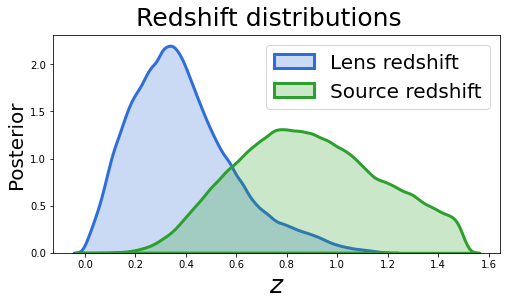

In [2]:
# ---------------------------------
telescope = 'LSST'
bandpasses = ['r', 'i', 'z', 'y']
# ---------------------------------

lsst = Telescope(telescope, bandpasses)

z_source_list_, z_lens_list_, theta_E_list_ = lsst.load_z_theta(theta_min=0.1)

lsst.plot_redshifts(z_lens_list_, z_source_list_)

### Seeing distributions
Sample the PSF from the predicted seeing distribution for the <b> baseline v2.0 </b> observing strategy for 10 years.

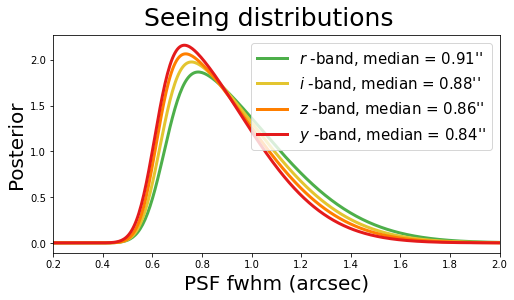

In [3]:
lsst.plot_seeing_distributions()


### Cadence

Sample the cadence from the predicted distribution for the <b> baseline v2.0 </b> observing strategy for the LSST Wide, Fast, Deep survey from Catarina Alves' simulations.


100%|██████████████████████████████████████████| 64/64 [00:00<00:00, 740.15it/s]


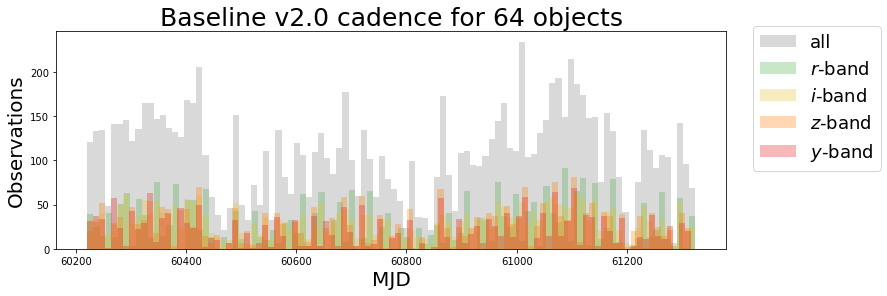

In [4]:
obs_times, obs_filters = lsst.load_cadence(small_sample=True)

obs_all, obs_r, obs_i, obs_z, obs_y = lsst.get_total_obs_times(obs_times, obs_filters)

lsst.plot_cadence(obs_times, obs_all, obs_r, obs_i, obs_z, obs_y)

### Generation of training and test sets


  0%|                                                     | 0/1 [00:00<?, ?it/s]

Detectable! Number of cadence tries:  2
 
Lens redshift:  0.5
Supernova redshift:  0.69
Einstein radius:  0.3
Time delays:  [ 0.   11.49] days
Macro magnification:  [2.03 1.78]
Microlensing contribution at peak (magnitudes):  0.0
Hubble constant:  97.61
Time-delay distance:  5606.13
Peak brightness images for r,i,z,y bands:
[[23.37 23.04]
 [22.64 22.67]
 [22.72 22.8 ]
 [22.96 22.67]]
 


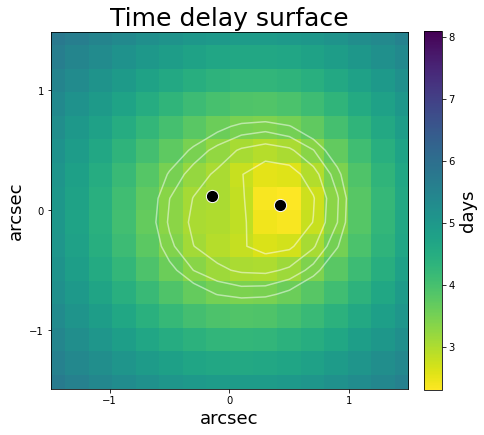

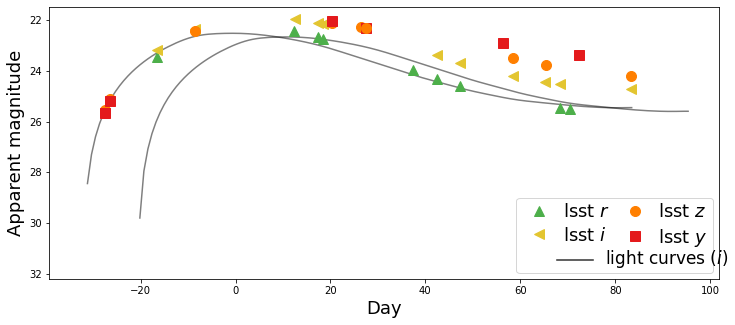

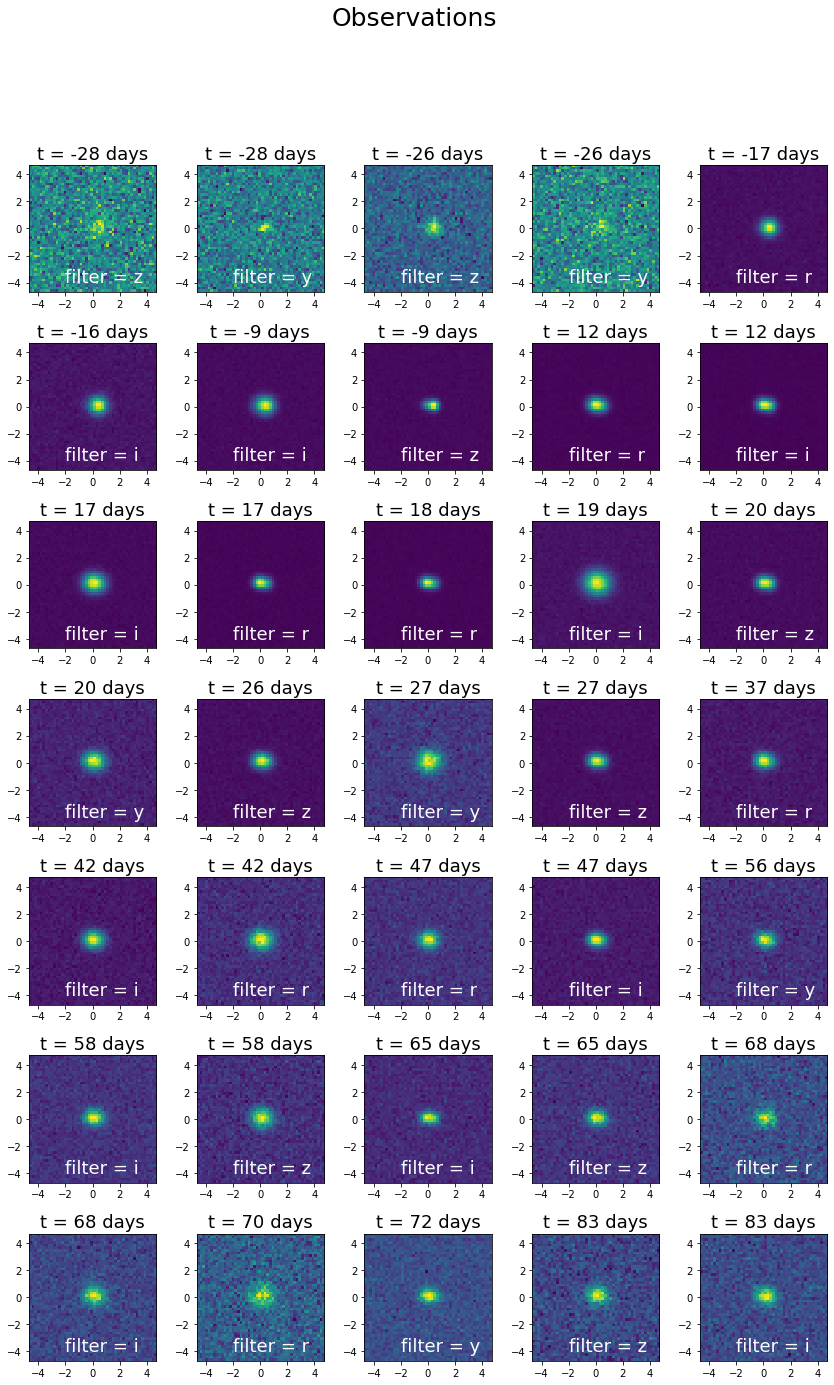

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.22s/it]

Timing results
Len:  1 261 253 1 0 0 0 0 2 1 1
 
Mean time:  0.01616692543029785 0.0004145724563306319 0.0014830031413805814 0.0018279552459716797 nan nan nan nan 0.03758132457733154 0.0024268627166748047 2.6446142196655273
 
Done!
Simulating images took  3.0 seconds ( 0.0 hours) to complete.
Number of image-time series generated:  1
Number of configurations tried:  2
Number of attempts:  262
 


100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.76s/it]

                                         time_series  z_source   z_lens  \
0  [[[0.05314681991965649, 2.038750447868291, -1....  0.685443  0.49525   

          H0   theta_E                                           obs_peak  \
0  97.612858  0.297812  [[23.372837357058895, 23.04173042266962], [22....   

                                           obs_times  \
0  [-27.593155403526907, -27.568655403527373, -26...   

                                           obs_bands  \
0  [z, y, z, y, r, i, i, z, r, i, i, r, r, i, z, ...   

                                       brightness_im  \
0  [[25.545777709919236, 1.7976931348623157e+308]...   

                                  macro_mag  ...  \
0  [2.0304877888506234, 1.7782706489477018]  ...   

                                         time_stamps  g1_shear  g2_shear  \
0  [0.0, 0.02449999999953434, 1.1687999999994645,... -0.002055  0.002095   

   micro_kappa micro_gamma micro_s  micro_peak   stretch    colour        Mb  
0          NaN    

In [13]:
num_samples = 1               # Total number of lens systems to be generated  
batch_size = 1                # Number of lens systems that is saved together in a batch
batch = 1                     # Starting number of the batch
num_images = 2                # Choose between 2 (for doubles) and 4 (for quads)
obs_upper_limit = 40          # Upper limit of number of observations
obs_lower_limit = 5           # Lower limit of number of observations
fixed_H0 = False              # Bool, if False: vary H0. if True: fix H0 to 70 km/s/Mpc (for the evaluation set)
add_microlensing = False      # Bool, if False: Only macro magnification. if True: Add effects of microlensing

Show = True                   # Bool, if True: Show figures and print information about the lens systems
Save = False                  # Bool, if True: Save image time-series
path = "../processed_data/Cadence_microlensing_evaluationset_doubles2/" # Path to folder in which to save the results


df = simulate_time_series_images(batch_size, batch,  num_samples, num_images, obs_times,
                                                 obs_filters, obs_all, z_source_list_, z_lens_list_, theta_E_list_, 
                                                 add_microlensing, telescope, bandpasses, 
                                                 obs_lower_limit, obs_upper_limit, fixed_H0, Show, Save, path)


### Retrieve light curve observations

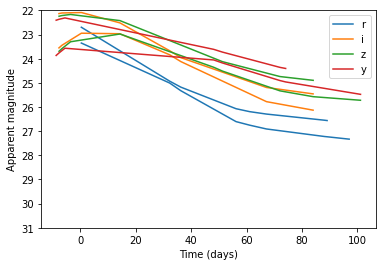

In [6]:
times = np.array(df['obs_times'][0])
bands = np.array(df['obs_bands'][0])
mags = df['brightness_im'][0]

mask_r = np.where(bands == 'r')
mask_i = np.where(bands == 'i')
mask_z = np.where(bands == 'z')
mask_y = np.where(bands == 'y')

plt.figure()
plt.plot(times[mask_r], mags[:,0][mask_r], color='C0', label="r")
plt.plot(times[mask_r], mags[:,1][mask_r], color='C0')

plt.plot(times[mask_i], mags[:,0][mask_i], color='C1', label="i")
plt.plot(times[mask_i], mags[:,1][mask_i], color='C1')

plt.plot(times[mask_z], mags[:,0][mask_z], color='C2', label="z")
plt.plot(times[mask_z], mags[:,1][mask_z], color='C2')

plt.plot(times[mask_y], mags[:,0][mask_y], color='C3', label="y")
plt.plot(times[mask_y], mags[:,1][mask_y], color='C3')

plt.ylim(31, 22)
plt.ylabel("Apparent magnitude")
plt.xlabel("Time (days)")
plt.legend()


In [7]:

"""
averages = [np.mean(t) for t in timings]
print(averages)
sums = [np.sum(t) for t in timings]
periods = [1,2,3,4,5,6,7,8,9,10,11]

plt.figure(1, figsize=(15, 5))
plt.plot(periods, averages[:11], '.', ms=10, color='midnightblue')

plt.figure(2, figsize=(15, 5))
plt.plot(periods, sums[:11], '.', ms=10, color='midnightblue')
"""

"\naverages = [np.mean(t) for t in timings]\nprint(averages)\nsums = [np.sum(t) for t in timings]\nperiods = [1,2,3,4,5,6,7,8,9,10,11]\n\nplt.figure(1, figsize=(15, 5))\nplt.plot(periods, averages[:11], '.', ms=10, color='midnightblue')\n\nplt.figure(2, figsize=(15, 5))\nplt.plot(periods, sums[:11], '.', ms=10, color='midnightblue')\n"

In [8]:
"""
plt.figure(3)
plt.plot([1,2], sums[11:], '.', ms=20, color="C3")
print(sums[11], sums[12])
print(averages[11], averages[12])
print(averages[6])
"""

'\nplt.figure(3)\nplt.plot([1,2], sums[11:], \'.\', ms=20, color="C3")\nprint(sums[11], sums[12])\nprint(averages[11], averages[12])\nprint(averages[6])\n'

In [9]:
# timings_200 = timings.copy()

In [10]:
"""
mmaverages = [np.mean(t) for t in mmtimings]
mmsums = [np.sum(t) for t in mmtimings]
mmperiods = [1,2,3,4,5,6,7]
print(mmaverages)
print(mmsums)

plt.figure(4, figsize=(15, 5))
plt.plot(mmperiods, mmaverages, '.', ms=10, color='C1')

plt.figure(5, figsize=(15, 5))
plt.plot(mmperiods, mmsums, '.', ms=10, color='C1')
"""

"\nmmaverages = [np.mean(t) for t in mmtimings]\nmmsums = [np.sum(t) for t in mmtimings]\nmmperiods = [1,2,3,4,5,6,7]\nprint(mmaverages)\nprint(mmsums)\n\nplt.figure(4, figsize=(15, 5))\nplt.plot(mmperiods, mmaverages, '.', ms=10, color='C1')\n\nplt.figure(5, figsize=(15, 5))\nplt.plot(mmperiods, mmsums, '.', ms=10, color='C1')\n"